In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation
import jieba
import os
import re
from openpyxl import Workbook
from datetime import datetime

**txt转化xlsx**

In [3]:
def process_cnki_txt(input_dir, output_file):
    # 定义需要排除的字段
    excluded_fields = {'Reference Type', 'Volume', 'Pages', 'Database Provider'}
    
    # 定义列顺序（排除不需要的字段后）
    columns_order = [
        'Title',
        'Author',
        'Author Address',
        'Journal',
        'Year',
        'Issue',
        'Keywords',
        'Abstract',
        'ISBN/ISSN',
        'Notes',
        'URL',
        'DOI'
    ]
    
    all_entries = []
    
    # 遍历输入目录下的所有txt文件
    for filename in os.listdir(input_dir):
        if filename.endswith('.txt'):
            filepath = os.path.join(input_dir, filename)
            
            with open(filepath, 'r', encoding='utf-8') as f:
                content = f.read().strip()
                
                # 分割不同文献条目（假设条目之间用空行分隔）
                entries = re.split(r'\n{2,}', content)
                
                for entry in entries:
                    entry_dict = {}
                    lines = entry.split('\n')
                    
                    for line in lines:
                        line = line.strip()
                        if not line:
                            continue
                        
                        # 使用正则表达式匹配字段
                        match = re.match(r'^\{(.+?)\}: (.+)$', line)
                        if match:
                            field = match.group(1)
                            value = match.group(2).strip()
                            
                            # 排除不需要的字段
                            if field not in excluded_fields:
                                entry_dict[field] = value
                    
                    # 创建符合列顺序的条目
                    ordered_entry = []
                    for col in columns_order:
                        # 处理可能缺失的字段
                        ordered_entry.append(entry_dict.get(col, ''))
                    
                    all_entries.append(ordered_entry)
    
    # 创建DataFrame并保存为Excel
    df = pd.DataFrame(all_entries, columns=columns_order)
    
    # 数据清洗：处理可能的空字符串
    df.replace({'': pd.NA}, inplace=True)
    
    # 保存结果
    df.to_excel(output_file, index=False)
    print(f'成功处理 {len(all_entries)} 篇文献，已保存到 {output_file}')

# 使用示例
input_directory = './data'  # 修改为你的txt文件目录
output_excel = './CNKI_papers.xlsx'  # 输出文件名

process_cnki_txt(input_directory, output_excel)

c:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:910: UserWarning: Ignoring URL 'https://kns.cnki.net/kcms2/article/abstract?v=0iq8nzQYh5Q__v-B1iEP1IbRuiMrEsoLEfvcqR_xbNODvqUAQN6GvuWqRR8qlXWaPezuAI3vYLE5I-9Ew2EwurdbrJpCjr7J3L-pYv8q7boBd6A0-IvjORA4TfWdZwXm8UG-2Z7GUNulAUL8sOXZtWoJEC8oQJhBaAFA4ViGAkXhmMKDZpB_figWgM_zUYjJHx0HEVlYnq8=&uniplatform=NZKPT&language=CHS' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
c:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:910: UserWarning: Ignoring URL 'https://kns.cnki.net/kcms2/article/abstract?v=0iq8nzQYh5RKJWIwmyBZD6nVIOgOlG0rAhqsjF1xSCCqvHYLs1e6WY8Sxg5ACAFzsL61zE1y0WFyPPrSIKEw3pi-riA2hxi9O7E6I0O2BcE5Nu9pCqsvN8uObHCH4hfUQHLvj9NQKbPlKwMcWAP_gA_ZZFB_vYt8QP4g48N52_cK1xRyfizpDG1jZybYMK_8VcIi-6WTHd8=&uniplatform=NZKPT&language=CHS' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
c:\ProgramData\Anaco

成功处理 4500 篇文献，已保存到 ./CNKI_papers.xlsx


**分sheet**

In [6]:
# 定义处理顺序（根据图片文件名排列）
THEME_ORDER = [
    "3D打印技术",
    "5G技术",
    "机器人",
    "量子计算",
    "人工智能",
    "卫星通信",
    "无人机",
    "新能源汽车",
    "自动驾驶"
]

def process_theme_txt(input_dir, output_file, max_records=500):
    # 创建Excel写入对象
    writer = pd.ExcelWriter(output_file, engine='openpyxl')
    
    # 遍历每个主题
    for theme in THEME_ORDER:
        filename = f"CNKI-{theme}.txt"
        filepath = os.path.join(input_dir, filename)
        
        # 读取并处理TXT文件
        entries = []
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                content = f.read().strip()
                
                # 分割文献条目
                raw_entries = re.split(r'\n{2,}', content)
                
                # 解析每个条目
                for entry in raw_entries[:max_records]:
                    entry_dict = {}
                    for line in entry.split('\n'):
                        line = line.strip()
                        if not line:
                            continue
                        match = re.match(r'^\{(.+?)\}: (.+)$', line)
                        if match:
                            field = match.group(1)
                            value = match.group(2).strip()
                            entry_dict[field] = value
                    entries.append(entry_dict)
        except FileNotFoundError:
            print(f"警告：未找到文件 {filename}")
            continue
        
        # 转换为DataFrame
        df = pd.DataFrame(entries)
        
        # 字段处理
        excluded_fields = {'Reference Type', 'Volume', 'Pages', 'Database Provider'}
        keep_columns = [col for col in df.columns if col not in excluded_fields]
        df = df[keep_columns]
        
        # 保存到Excel Sheet
        df.head(max_records).to_excel(
            writer,
            sheet_name=theme[:31],  # Excel限制Sheet名称长度
            index=False
        )
    
    # 保存并优化格式
    writer.close()
    print(f"处理完成，结果已保存至：{output_file}")

# 使用示例
input_directory = "./data"  # 原始TXT文件目录
output_excel = "classified_papers.xlsx"  # 输出文件名

process_theme_txt(input_directory, output_excel)

处理完成，结果已保存至：classified_papers.xlsx


**数据缺失统计**

各列缺失值统计：
                总记录数  缺失值数量  缺失率(%)     数据类型        分析日期
DOI             4500   2786   61.91   object  2025-03-31
URL             4500   2291   50.91   object  2025-03-31
Keywords        4500    443    9.84   object  2025-03-31
Year            4500    349    7.76  float64  2025-03-31
Issue           4500    349    7.76   object  2025-03-31
Author Address  4500    225    5.00   object  2025-03-31
Author          4500    129    2.87   object  2025-03-31
Abstract        4500      5    0.11   object  2025-03-31
ISBN/ISSN       4500      3    0.07   object  2025-03-31
Notes           4500      3    0.07   object  2025-03-31
Title           4500      0    0.00   object  2025-03-31
Journal         4500      0    0.00   object  2025-03-31


c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning: Glyph 32570 (\N{CJK UNIFIED IDEOGRAPH-7F3A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:125: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  fig.canvas.print_figure(bytes_

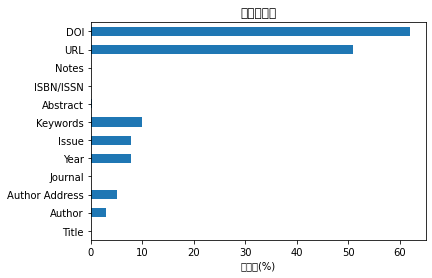

In [4]:
def analyze_missing_values(file_path):
    """统计Excel文件各列的缺失值情况"""
    # 读取Excel文件（网页3/6方法）
    df = pd.read_excel(file_path)
    
    # 统计缺失值（网页3核心方法）
    missing_count = df.isnull().sum()
    missing_rate = missing_count / len(df) * 100
    
    # 创建统计结果表（网页6展示方式增强）
    stats_df = pd.DataFrame({
        '总记录数': len(df),
        '缺失值数量': missing_count,
        '缺失率(%)': missing_rate.round(2),
        '数据类型': df.dtypes.values
    })
    
    # 添加时间戳（网页1的规范建议）
    stats_df['分析日期'] = datetime(2025, 3, 31).strftime('%Y-%m-%d')
    
    # 输出结果（网页3/6组合方案）
    print("各列缺失值统计：")
    print(stats_df.sort_values('缺失率(%)', ascending=False))
    
    return stats_df

# 使用示例（假设文件在当前目录）
result = analyze_missing_values("cnki_papers.xlsx")

# 可选：保存统计结果
result.to_excel("missing_value_report.xlsx", index_label='字段名称')
result['缺失率(%)'].plot(kind='barh', title='缺失值分布')
plt.xlabel('缺失率(%)')
plt.show()

**清洗数据**

In [5]:
def clean_missing_data(input_file, output_file):
    """删除指定字段缺失的数据行"""
    # 读取Excel文件（保留原始数据格式）
    df = pd.read_excel(input_file, engine='openpyxl')
    
    # 初始数据统计
    original_count = len(df)
    print(f"原始数据记录数：{original_count}")
    
    # 定义需要严格检查的字段[6,7](@ref)
    required_fields = ['Keywords', 'Author Address', 'Author', 'Abstract']
    
    # 执行删除操作（删除任意指定字段缺失的行）[7](@ref)
    cleaned_df = df.dropna(
        subset=required_fields,
        how='any',
        axis=0
    )
    
    # 结果统计
    cleaned_count = len(cleaned_df)
    removed_count = original_count - cleaned_count
    print(f"删除缺失记录：{removed_count} 条")
    print(f"有效保留记录：{cleaned_count} 条")
    
    # 数据保存（添加时间戳标记）[1](@ref)
    timestamp = datetime.now().strftime("%Y%m%d")
    final_output = f"{output_file.split('.')[0]}_{timestamp}.xlsx"
    
    cleaned_df.to_excel(final_output, index=False)
    print(f"清洗后数据已保存至：{final_output}")
    # 验证清洗结果
    assert cleaned_df[required_fields].isnull().sum().sum() == 0

# 使用示例
input_file = "CNKI_papers.xlsx"  # 输入文件路径
output_file = "cleaned_papers.xlsx"  # 输出文件路径

clean_missing_data(input_file, output_file)

原始数据记录数：4500
删除缺失记录：451 条
有效保留记录：4049 条
清洗后数据已保存至：cleaned_papers_20250331.xlsx


In [8]:
THEME_ORDER = [
    "3D打印技术",
    "5G技术",
    "机器人",
    "量子计算",
    "人工智能",
    "卫星通信",
    "无人机",
    "新能源汽车",
    "自动驾驶"
]

EXCLUDED_FIELDS = {'Reference Type', 'Volume', 'Pages', 'Database Provider'}
REQUIRED_FIELDS = ['Keywords', 'Author Address', 'Author', 'Abstract']

def process_theme_data(input_dir, output_file):
    """分页处理并清洗数据（Python 3.7兼容版）"""
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        for theme in THEME_ORDER:
            entries = []
            filepath = os.path.join(input_dir, f"CNKI-{theme}.txt")
            
            # 读取并解析数据
            if os.path.exists(filepath):
                with open(filepath, 'r', encoding='utf-8') as f:
                    raw_entries = re.split(r'\n{2,}', f.read().strip())
                    
                    for entry in raw_entries:
                        entry_dict = {}
                        for line in entry.split('\n'):
                            # 改造点：拆分海象运算符
                            match = re.match(r'^\{(.+?)\}: (.+)$', line.strip())
                            if match:  # 传统条件判断代替海象运算符
                                field, value = match.groups()
                                entry_dict[field.strip()] = value.strip()
                        entries.append(entry_dict)

            # 转换为DataFrame并清洗
            if entries:
                df = pd.DataFrame(entries)
                df = df[[col for col in df.columns if col not in EXCLUDED_FIELDS]]
                df_clean = df.dropna(subset=REQUIRED_FIELDS, how='any')
                
                df_clean.to_excel(
                    writer,
                    sheet_name=theme[:31],
                    index=False
                )
                
                print(f"{theme}：原始 {len(df)} 条 → 清洗后 {len(df_clean)} 条")
            else:
                print(f"{theme}：无有效数据")

# 使用示例
input_dir = "./data"
output_file = f"分页清洗数据_{datetime.now().strftime('%Y%m%d')}.xlsx"
process_theme_data(input_dir, output_file)

3D打印技术：原始 500 条 → 清洗后 500 条
5G技术：原始 500 条 → 清洗后 500 条
机器人：原始 500 条 → 清洗后 500 条
量子计算：原始 500 条 → 清洗后 292 条
人工智能：原始 500 条 → 清洗后 451 条
卫星通信：原始 500 条 → 清洗后 424 条
无人机：原始 500 条 → 清洗后 464 条
新能源汽车：原始 500 条 → 清洗后 421 条
自动驾驶：原始 500 条 → 清洗后 497 条


**标签分类**

In [14]:
# 新增全局字体配置（网页1/6/7方法）
plt.rcParams['font.family'] = 'SimHei'  # 设置为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def process_clusters(input_file):
    # 读取分页数据
    xls = pd.ExcelFile(input_file)
    results = []

    for sheet_name in xls.sheet_names:
        # 读取单页数据
        df = pd.read_excel(xls, sheet_name=sheet_name)
        
        # 数据预处理
        df['combined_text'] = df['Keywords'].fillna('') + ";" + df['Journal'].fillna('')
        texts = [' '.join(jieba.cut(str(text))) for text in df['combined_text']]

        # 特征工程
        tfidf = TfidfVectorizer(max_features=500)
        tfidf_matrix = tfidf.fit_transform(texts)

        # 动态确定聚类数量（网页3/5/8方法）
        best_k = determine_optimal_clusters(tfidf_matrix)
        
        # 执行聚类（网页7/8方法）
        kmeans = KMeans(n_clusters=best_k, random_state=42)
        clusters = kmeans.fit_predict(tfidf_matrix)
        
        # 主题命名（网页2/5方法）
        lda = LatentDirichletAllocation(n_components=best_k)
        lda.fit(tfidf_matrix)
        cluster_labels = extract_topic_labels(lda, tfidf)
        
        # 结果统计
        cluster_df = pd.DataFrame({
            'Cluster': clusters,
            'Label': [cluster_labels[i] for i in clusters]
        })
        result_df = cluster_df['Label'].value_counts().reset_index()
        result_df.columns = ['主题类别', '文献数量']
        
        # 可视化存储
        save_visualization(result_df, sheet_name)
        results.append((sheet_name, result_df))
    
    # 生成汇总报告
    generate_summary_report(results)

def determine_optimal_clusters(matrix):
    """基于轮廓系数确定最佳聚类数（网页5方法）"""
    max_k = min(10, matrix.shape[0]-1)
    best_score = -1
    optimal_k = 2
    
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(matrix)
        score = silhouette_score(matrix, labels)
        if score > best_score:
            best_score = score
            optimal_k = k
    return optimal_k

def extract_topic_labels(model, vectorizer):
    """精简版标签生成器（每个主题1-2个关键词）"""
    feature_names = vectorizer.get_feature_names_out()
    labels = []
    for topic_idx, topic in enumerate(model.components_):
        # 仅提取前两个关键特征（网页8方法改造）
        top_features = [feature_names[i] for i in topic.argsort()[:-3:-1]]  # 修改切片范围
        # 智能合并标签（新增逻辑）
        if len(top_features) >= 2:
            labels.append(f"{top_features[0]}-{top_features[1]}")
        else:
            labels.append(top_features[0])
    return labels

def save_visualization(df, sheet_name):
    """优化后的可视化模块"""
    plt.figure(figsize=(8,8))
    # 添加标签旋转避免重叠（网页3方法增强）
    plt.pie(df['文献数量'], 
            labels=df['主题类别'],
            autopct='%1.1f%%',
            startangle=90,
            textprops={'fontsize': 10})
    
    plt.title(f"{sheet_name}主题分布", pad=20, fontsize=14)
    plt.tight_layout()
    plt.savefig(f"./theme/{sheet_name}_主题分布.png", dpi=300)
    plt.close()

def generate_summary_report(results):
    """生成多页汇总报告（网页4方法）"""
    with pd.ExcelWriter('聚类分析报告.xlsx') as writer:
        for sheet_name, df in results:
            df.to_excel(writer, sheet_name=sheet_name[:31], index=False)

# 使用示例
process_clusters("分页清洗数据_20250331.xlsx")

**数据评估**

In [7]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt

def process_sheets(input_file, output_folder):
    """处理Excel所有工作表并保存结果"""
    # 创建带时间戳的文件夹[2,5](@ref)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_path = os.path.join(output_folder, f"processed_{timestamp}")
    os.makedirs(output_path, exist_ok=True)
    
    # 读取所有工作表[4](@ref)
    sheets = pd.read_excel(input_file, sheet_name=None)
    
    quality_report = {
        '完整性': [],
        '准确性': [],
        '一致性': [],
        '异常记录': []
    }

    # 遍历处理每个工作表[2](@ref)
    for sheet_name, df in sheets.items():
        # 数据清洗：去除空行
        cleaned_df = df.dropna(how='all')
        
        # 质量评估
        quality_metrics = {
            '完整性': round(1 - df.isnull().mean().mean(), 2),
            '准确性': validate_data(cleaned_df),
            '一致性': check_consistency(cleaned_df)
        }
        
        # 保存处理结果[2](@ref)
        sheet_folder = os.path.join(output_path, sheet_name)
        os.makedirs(sheet_folder, exist_ok=True)
        cleaned_df.to_excel(os.path.join(sheet_folder, f"{sheet_name}_processed.xlsx"), index=False)
        
        # 收集质量指标
        for k, v in quality_metrics.items():
            quality_report[k].append(v)
        
    # 生成综合报告
    generate_report(quality_report, output_path)
    return output_path

def validate_data(df):
    """准确性验证[7](@ref)"""
    # 示例验证规则：数值列非负
    numeric_cols = df.select_dtypes(include='number').columns
    error_rate = df[numeric_cols].apply(lambda x: (x < 0).sum()).sum() / df.size
    return round(1 - error_rate, 2)

def check_consistency(df):
    """一致性检查[8](@ref)"""
    # 检查日期格式一致性
    date_cols = [col for col in df.columns if 'date' in col.lower()]
    if date_cols:
        return df[date_cols].apply(lambda x: x.str.contains(r'\d{4}-\d{2}-\d{2}').mean()).mean()
    return 1.0

def generate_report(report, path):
    """生成可视化报告[6,8](@ref)"""
    # 数据质量评分
    scores = {k: sum(v)/len(v) for k, v in report.items() if k != '异常记录'}
    
    # 可视化仪表盘
    plt.figure(figsize=(15, 10))
    
    # 质量评分雷达图
    plt.subplot(2, 2, 1, polar=True)
    categories = list(scores.keys())
    values = list(scores.values())
    plt.fill(categories, values, alpha=0.25)
    
    # 完整性分布直方图
    plt.subplot(2, 2, 2)
    pd.Series(report['完整性']).hist()
    plt.title('各工作表完整性分布')
    
    # 保存报告
    report_path = os.path.join(path, "质量评估报告.pdf")
    plt.savefig(report_path)
    plt.close()
    
    # 生成文本报告
    text_report = f"""
    === 综合数据质量评估报告 ===
    生成时间：{datetime.now().strftime("%Y-%m-%d %H:%M")}
    
    核心指标：
    - 平均完整性：{scores['完整性']*100}%
    - 平均准确性：{scores['准确性']*100}%
    - 平均一致性：{scores['一致性']*100}%
    
    详细指标：
    1. 完整性分布范围：{min(report['完整性'])*100}% ~ {max(report['完整性'])*100}%
    2. 异常工作表列表：{[i for i, v in enumerate(report['完整性']) if v < 0.9]}
    """
    with open(os.path.join(path, "报告摘要.txt"), 'w') as f:
        f.write(text_report)

# 执行示例
if __name__ == "__main__":
    output = process_sheets(
        input_file="分页清洗数据.xlsx",
        output_folder="out"
    )
    print(f"处理完成！结果保存在：{output}")

c:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:910: UserWarning: Ignoring URL 'https://kns.cnki.net/kcms2/article/abstract?v=0iq8nzQYh5Q__v-B1iEP1IbRuiMrEsoLEfvcqR_xbNODvqUAQN6GvuWqRR8qlXWaPezuAI3vYLE5I-9Ew2EwurdbrJpCjr7J3L-pYv8q7boBd6A0-IvjORA4TfWdZwXm8UG-2Z7GUNulAUL8sOXZtWoJEC8oQJhBaAFA4ViGAkXhmMKDZpB_figWgM_zUYjJHx0HEVlYnq8=&uniplatform=NZKPT&language=CHS' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
c:\ProgramData\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:910: UserWarning: Ignoring URL 'https://kns.cnki.net/kcms2/article/abstract?v=0iq8nzQYh5RKJWIwmyBZD6nVIOgOlG0rAhqsjF1xSCCqvHYLs1e6WY8Sxg5ACAFzsL61zE1y0WFyPPrSIKEw3pi-riA2hxi9O7E6I0O2BcE5Nu9pCqsvN8uObHCH4hfUQHLvj9NQKbPlKwMcWAP_gA_ZZFB_vYt8QP4g48N52_cK1xRyfizpDG1jZybYMK_8VcIi-6WTHd8=&uniplatform=NZKPT&language=CHS' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
c:\ProgramData\Anaco

处理完成！结果保存在：out\processed_20250331_204508
